In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from google.colab import files
files.upload()

Saving spam.csv to spam.csv


{'spam.csv': b'v1,v2,,,\r\nham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,\r\nham,Ok lar... Joking wif u oni...,,,\r\nspam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C\'s apply 08452810075over18\'s,,,\r\nham,U dun say so early hor... U c already then say...,,,\r\nham,"Nah I don\'t think he goes to usf, he lives around here though",,,\r\nspam,"FreeMsg Hey there darling it\'s been 3 week\'s now and no word back! I\'d like some fun you up for it still? Tb ok! XxX std chgs to send, \xe5\xa31.50 to rcv",,,\r\nham,Even my brother is not like to speak with me. They treat me like aids patent.,,,\r\nham,As per your request \'Melle Melle (Oru Minnaminunginte Nurungu Vettam)\' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,\r\nspam,WINNER!! As a valued network customer you have been selected to rece

In [5]:
with open("spam.csv", "rb") as rawdata:
        result = chardet.detect(rawdata.read(10000))

In [6]:
df = pd.read_csv("spam.csv", encoding=result['encoding'])
    df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
    df = df.rename(columns={'v1': 'label', 'v2': 'message'})
    df['label_encoding'] = df['label'].map({'ham': 0, 'spam': 1})
    # print(df)

IndentationError: ignored

In [7]:
df = pd.read_csv("spam.csv", encoding=result['encoding'])
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df['label_encoding'] = df['label'].map({'ham': 0, 'spam': 1})
print(df)

     label                                            message  label_encoding
0      ham  Go until jurong point, crazy.. Available only ...               0
1      ham                      Ok lar... Joking wif u oni...               0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...               1
3      ham  U dun say so early hor... U c already then say...               0
4      ham  Nah I don't think he goes to usf, he lives aro...               0
...    ...                                                ...             ...
5567  spam  This is the 2nd time we have tried 2 contact u...               1
5568   ham              Will Ì_ b going to esplanade fr home?               0
5569   ham  Pity, * was in mood for that. So...any other s...               0
5570   ham  The guy did some bitching but I acted like i'd...               0
5571   ham                         Rofl. Its true to its name               0

[5572 rows x 3 columns]


In [8]:
x, y = np.asanyarray(df['message']), np.asanyarray(df['label_encoding'])

new_df = pd.DataFrame({'message': x, 'label': y})
print(new_df)

                                                message  label
0     Go until jurong point, crazy.. Available only ...      0
1                         Ok lar... Joking wif u oni...      0
2     Free entry in 2 a wkly comp to win FA Cup fina...      1
3     U dun say so early hor... U c already then say...      0
4     Nah I don't think he goes to usf, he lives aro...      0
...                                                 ...    ...
5567  This is the 2nd time we have tried 2 contact u...      1
5568              Will Ì_ b going to esplanade fr home?      0
5569  Pity, * was in mood for that. So...any other s...      0
5570  The guy did some bitching but I acted like i'd...      0
5571                         Rofl. Its true to its name      0

[5572 rows x 2 columns]


In [9]:
x_train, x_test, y_train, y_test = train_test_split(
        new_df['message'], new_df['label'], test_size=0.2, random_state=42)

tfidf_vec = TfidfVectorizer().fit(x_train)
x_train_vec, x_test_vec = tfidf_vec.transform(
    x_train), tfidf_vec.transform(x_test)

baseline_model = MultinomialNB()
baseline_model.fit(x_train_vec, y_train)

bm_accuracy = accuracy_score(y_test, baseline_model.predict(x_test_vec))

In [10]:
print(bm_accuracy)

0.9623318385650225


In [11]:
print(classification_report(y_test, baseline_model.predict(x_test_vec)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [15]:
from tensorflow.keras.layers import TextVectorization

In [18]:
avg_words_len=round(sum([len(i.split()) for i in df['message']])/len(df['message']))
print(avg_words_len)

15


In [20]:
s = set()
for sent in df['message']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [21]:
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

In [23]:
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(x_train)

In [24]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [25]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
l = layers.GlobalAveragePooling1D()(embedding_layer_model)
l = layers.Flatten()(l)
l = layers.Dense(32, activation='relu')(l)
output_layer = layers.Dense(1, activation='sigmoid')(l)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [26]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [27]:
history_1 = model_1.fit(x_train, y_train, epochs=5, validation_data = (x_test,y_test), validation_steps = int(0.2*len(x_test)))

Epoch 1/5
140/140 [==============================] - 4s 22ms/step - loss: 0.6052 - accuracy: 0.9114 - val_loss: 0.5774 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 2s 15ms/step - loss: 0.5701 - accuracy: 0.9883 - val_loss: 0.5732 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 2s 16ms/step - loss: 0.5658 - accuracy: 0.9957 - val_loss: 0.5729 - val_accuracy: 0.9830
Epoch 4/5
140/140 [==============================] - 2s 16ms/step - loss: 0.5642 - accuracy: 0.9980 - val_loss: 0.5723 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 2s 16ms/step - loss: 0.5635 - accuracy: 0.9987 - val_loss: 0.5726 - val_accuracy: 0.9812


In [28]:
pd.DataFrame(history_1.history).plot()

<Axes: >

In [29]:
df_created = pd.DataFrame(history_1.history)

In [30]:
print(df_created)

       loss  accuracy  val_loss  val_accuracy
0  0.605155  0.911375  0.577357      0.972197
1  0.570101  0.988333  0.573222      0.982960
2  0.565809  0.995737  0.572860      0.982960
3  0.564248  0.997981  0.572269      0.982063
4  0.563476  0.998654  0.572561      0.981166


In [32]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [33]:

import tensorflow_hub as hub

In [34]:
model_3 = keras.Sequential()
 
# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
 
compile_model(model_3)
 
history_3 = fit_model(model_3, epochs=5)

NameError: ignored

In [36]:
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, x_train=x_train, y_train=y_train,
              x_test=x_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        validation_steps=int(0.2*len(x_test)))
    return history
 
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

In [37]:
model_3 = keras.Sequential()
 
# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
 
compile_model(model_3)
 
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 6s 26ms/step - loss: 0.2881 - accuracy: 0.9192 - val_loss: 0.1125 - val_accuracy: 0.9686
Epoch 2/5
140/140 [==============================] - 3s 18ms/step - loss: 0.0802 - accuracy: 0.9787 - val_loss: 0.0723 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 3s 18ms/step - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.0590 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 2s 16ms/step - loss: 0.0455 - accuracy: 0.9863 - val_loss: 0.0533 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0387 - accuracy: 0.9892 - val_loss: 0.0498 - val_accuracy: 0.9821


In [39]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
l2 = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(l2)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5
140/140 [==============================] - 17s 68ms/step - loss: 0.0567 - accuracy: 0.9874 - val_loss: 0.0918 - val_accuracy: 0.9830
Epoch 2/5
140/140 [==============================] - 8s 58ms/step - loss: 1.5579e-04 - accuracy: 1.0000 - val_loss: 0.1172 - val_accuracy: 0.9839
Epoch 3/5
140/140 [==============================] - 7s 53ms/step - loss: 3.9932e-05 - accuracy: 1.0000 - val_loss: 0.1265 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 8s 57ms/step - loss: 2.2017e-05 - accuracy: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 8s 55ms/step - loss: 1.3811e-05 - accuracy: 1.0000 - val_loss: 0.1384 - val_accuracy: 0.9848


In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [41]:
model_1.summary()
model_2.summary()
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

<Axes: >

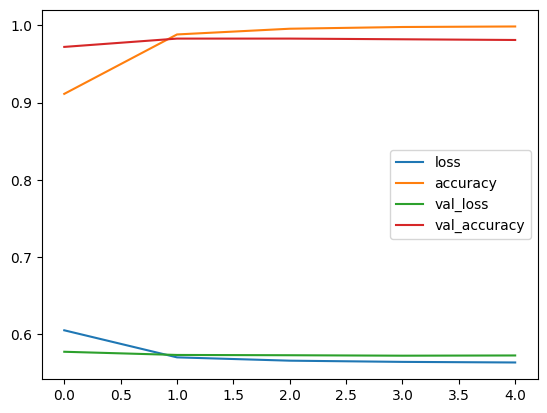

In [44]:
pd.DataFrame(history_1.history).plot()
pd.DataFrame(history_2.history).plot()
pd.DataFrame(history_3.history).plot()

In [55]:
pd.DataFrame(history_1.history)

loss  accuracy  val_loss  val_accuracy
0  0.605155  0.911375  0.577357      0.972197
1  0.570101  0.988333  0.573222      0.982960
2  0.565809  0.995737  0.572860      0.982960
3  0.564248  0.997981  0.572269      0.982063
4  0.563476  0.998654  0.572561      0.981166

In [58]:
pd.DataFrame(history_2.history)

loss  accuracy  val_loss  val_accuracy
0  0.056652  0.987436  0.091824      0.982960
1  0.000156  1.000000  0.117154      0.983856
2  0.000040  1.000000  0.126536      0.983856
3  0.000022  1.000000  0.133066      0.983856
4  0.000014  1.000000  0.138388      0.984753

In [57]:
pd.DataFrame(history_3.history)

loss  accuracy  val_loss  val_accuracy
0  0.288138  0.919228  0.112511      0.968610
1  0.080153  0.978685  0.072328      0.976682
2  0.057388  0.983173  0.059020      0.980269
3  0.045474  0.986314  0.053312      0.981166
4  0.038741  0.989230  0.049814      0.982063